# CycleAtlanta: Speed and Acceleration Examination
Visualize the speed and acceleration plots by trip or look at the distribution of riding speeds for accross a subset of trips and/or users.

In [1]:
from pathlib import Path
import pickle
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
import contextily as cx
import numpy.ma as ma
from pykalman import KalmanFilter

import gps_utils

In [2]:
import json
config = json.load((Path.cwd() / 'config.json').open('rb'))
export_fp = Path(config['project_directory']) / 'CycleAtlanta'

In [3]:
with (export_fp/'coords_0.pkl').open('rb') as fh:
    coords_dict = pickle.load(fh)

# Reported vs Displacement Speeds
How trustworthy are the included mph metrics?

NaN speeds

In [10]:
is_nan = [tripid for tripid, coords in coords_dict.items() if (coords_dict[tripid]['speed_mph'].isna()).any()]
print(len(is_nan),'trips have at least one nan speed value.')

10107 trips have at least one nan speed value.


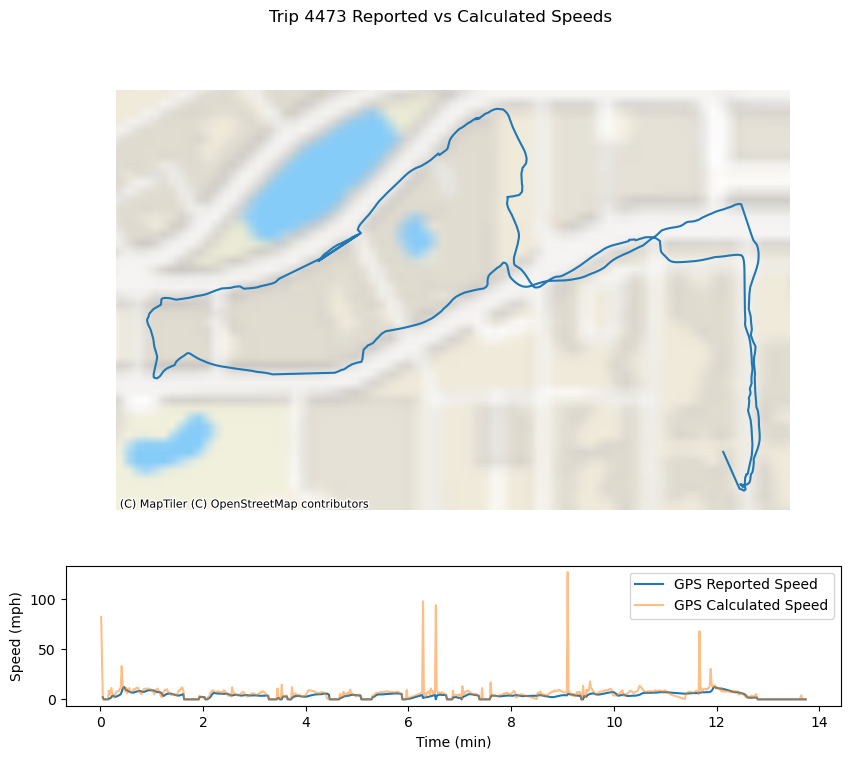

In [15]:
import random
choice_set = is_nan # list(coords_dict.keys())
random_key = random.choice(choice_set)
test = coords_dict[random_key]

test = gps_utils.calculate_coordinate_metrics(test)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10, 8),gridspec_kw={'height_ratios': [3, 1]})

fig.suptitle(f'Trip {random_key} Reported vs Calculated Speeds')
ax2.plot(test['time_elapsed'].dt.total_seconds() / 60,test['speed_mph'],label='GPS Reported Speed')
ax2.plot(test['time_elapsed'].dt.total_seconds() / 60,test['calculated_speed_mph'],alpha=0.5,label='GPS Calculated Speed')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Speed (mph)')
ax2.legend()

ax1.plot(test['X'],test['Y'])
ax1.axis('off')
cx.add_basemap(ax1,zoom=13,source=cx.providers.MapTiler.Streets(key=config['maptilerapikey']),crs=config['projected_crs_epsg'])

In [13]:
test[['geometry']].explore()

In [4]:
above_47 = [tripid for tripid, coords in coords_dict.items() if (coords_dict[tripid]['speed_mph'] > 47).any()]
above_47_calc = [tripid for tripid, coords in coords_dict.items() if (gps_utils.calculate_coordinate_metrics(coords_dict[tripid])['calculated_speed_mph'] > 47).any()]


In [5]:
print(len(above_47),' / ',len(coords_dict.keys()),'trips have a point above 47 mph')
print(len(above_47_calc),' / ',len(coords_dict.keys()),'trips have a point above 47 mph when using GPS point displacement to calculate speed')

204  /  23762 trips have a point above 47 mph
18820  /  23762 trips have a point above 47 mph when using GPS point displacement to calculate speed


GPS calculated speeds are very noisy with many above 47 mph, so perhaps not a good way to reduce number of points.

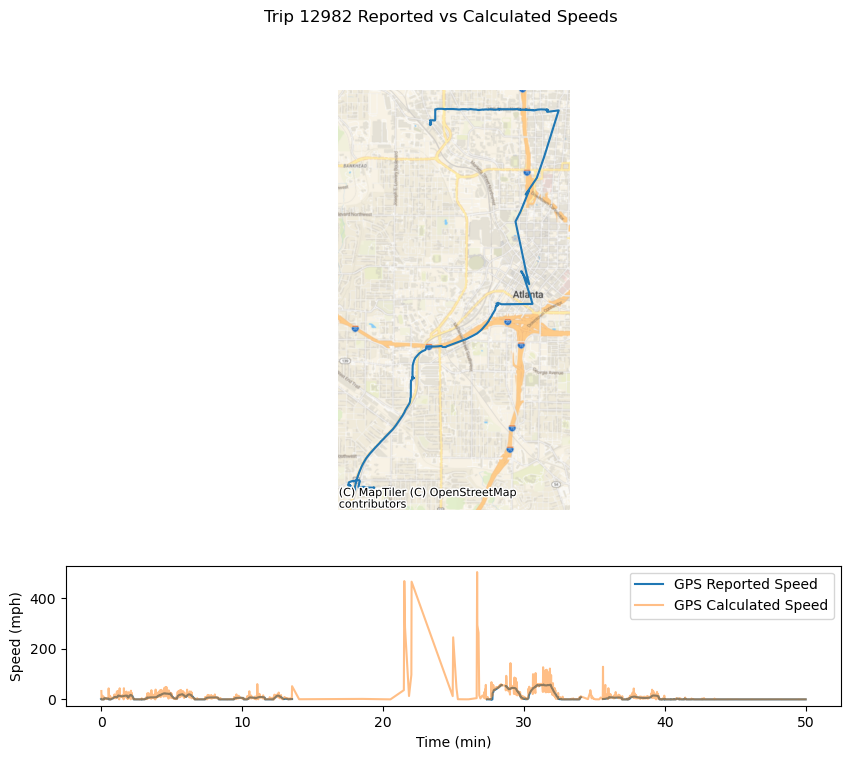

In [6]:
import random
choice_set = above_47 # list(coords_dict.keys())
random_key = random.choice(choice_set)
test = coords_dict[random_key]

test = gps_utils.calculate_coordinate_metrics(test)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10, 8),gridspec_kw={'height_ratios': [3, 1]})

fig.suptitle(f'Trip {random_key} Reported vs Calculated Speeds')
ax2.plot(test['time_elapsed'].dt.total_seconds() / 60,test['speed_mph'],label='GPS Reported Speed')
ax2.plot(test['time_elapsed'].dt.total_seconds() / 60,test['calculated_speed_mph'],alpha=0.5,label='GPS Calculated Speed')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Speed (mph)')
ax2.legend()

ax1.plot(test['X'],test['Y'])
ax1.axis('off')
cx.add_basemap(ax1,zoom=13,source=cx.providers.MapTiler.Streets(key=config['maptilerapikey']),crs=config['projected_crs_epsg'])

Quick Export

In [12]:
test[['delta_distance_ft','speed_mph','calculated_speed_mph','geometry']].to_file(Path.home()/'Downloads/scratch.gpkg',layer='devation')

What about hAccruacy?

In [8]:
test.columns

Index(['tripid', 'datetime', 'lat', 'lon', 'speed_mph', 'hAccuracy_ft',
       'geometry', 'X', 'Y', 'acceleration_ft/s**2', 'delta_time',
       'delta_distance_ft', 'traversed_distance_ft', 'time_elapsed',
       'calculated_speed_mph', 'sequence'],
      dtype='object')

In [ ]:
speeds = (test['delta_distance_ft'] / 5280) / (test['delta_time'].dt.total_seconds() / 60 / 60)

In [ ]:
test.loc[test['delta_distance_ft'].idxmax()]

For each trip what's the difference in speeds?

In [ ]:
test['speed_mph'] - test['calculated_speed_mph']

In [ ]:
test['calculated_speed_mph'].max()

In [ ]:
above_47 = [tripid for tripid, coords in coords_dict.items() if (coords_dict[tripid]['speed_mph'] > 47).any()]
above_47_calc = [tripid for tripid, coords in coords_dict.items() if (gps_utils.calculate_coordinate_metrics(coords_dict[tripid])['calculated_speed_mph'] > 47).any()]

In [ ]:
len(above_47)

In [ ]:
len(above_47_calc)

In [ ]:
test[['speed_mph','calculated_speed_mph','geometry']].explore('speed_mph')

In [ ]:
def kalman_speed(to_smooth):
    '''
    Use kalman filter to smooth out speed data and interpolate acceleration data using
    recorded speed and timestamps. Uses basic kinematics with a constant speed assumption.

    Take in series/arrays of speed and timestamp and output the smoothed speeds and estimated
    accelerations.

    Assumes second by second data, so any missing timestamps and filled in and the speed is
    interpolated.

    Adapted code from this:
    https://stackoverflow.com/questions/43377626/how-to-use-kalman-filter-in-python-for-location-data
    
    Read this for more about kalman filters: https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/
    
    '''

    #create nan entries to fill in missing data
    fill = pd.DataFrame(data={'time_elapsed_sec':range(0,to_smooth['time_elapsed_sec'].max()+1)})
    fill = pd.merge(fill,to_smooth,on='time_elapsed_sec',how='left')
    measurements = fill[['speed_fps']].to_numpy()
    
    #use np.ma to mask missing data
    measurements = ma.masked_array(measurements, mask=np.isnan(measurements))
    measurements.shape

    # the initial state of the cyclist (position = 0, speed = 0, and acceleration = 0)
    initial_state_mean = [0,0,0]
        
    #these are the kinematics of how we're moving assuming a constant speed (ignores elevation, signals, stop signs, etc)
    transition_matrix = [[1,1,1], # position_t-1 + speed_t-1 * t + acceleration_t-1 * t^2
                            [0,1,1], # speed_t = 0 + speed_t-1 + acceleration_t-1 * t
                            [0,0,1]]

    measurement_matrix = [[0,1,0]]

    #estimate a kalman filter
    kf1 = KalmanFilter(transition_matrices = transition_matrix,
                        observation_matrices = measurement_matrix,
                        initial_state_mean = initial_state_mean,
                        )

    #smooth the data
    (smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements)
 
    #convert to dataframe
    smoothed = pd.DataFrame(smoothed_state_means,columns=['smoothed_position_ft','smoothed_speed_fps','smoothed_acceleration_ft/s**2'])

    #get mph
    smoothed['smoothed_speed_mph'] = smoothed['smoothed_speed_fps'] / 5280 * 60

    #reset index and rename to elapsed time
    smoothed.reset_index(inplace=True)
    smoothed.rename(columns={'index':'time_elapsed_sec'},inplace=True)

    return smoothed

In [ ]:
with (Path.home()/'Documents/BikewaySimData/Projects/gdot/gps_traces/raw_coords.pkl').open('rb') as fh:
    coords_dict, trips = pickle.load(fh)

In [ ]:
tripid = 63
test_trace = coords_dict[tripid].copy()

In [ ]:
test_trace.columns

In [ ]:
test_trace = calculate_coordinate_metrics(test_trace)
test_trace

In [ ]:


#convert speed in miles per hour to ft/s
test_trace['speed_fps'] = test_trace['speed_mph'] * 5280 / 60

test_trace['calc_acceleration_ft/s**2'] = test_trace['speed_fps'].diff()

#make a time elapsed in seconds column
test_trace['time_elapsed_sec'] = test_trace['datetime'].apply(lambda x: int((x - test_trace['datetime'].min()).total_seconds()))

#smooth speed and interpolate acceleration
test_smoothed = kalman_speed(test_trace)
test_smoothed

In [ ]:
#merge with orignal data (gets rid of interpolated data)
merged = pd.merge(test_trace,test_smoothed, on='time_elapsed_sec')


# Plot example
Compare the calculated speed, cell phone recorded speeds, and the kalman smoothed speeds.

In [ ]:
# Plotting the original data and the moving average
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figwidth(10)

ax.scatter(merged['time_elapsed_sec'],merged['speed_mph'], marker='o', color='b', label='Speed')
ax.scatter(merged['time_elapsed_sec'],merged['smoothed_speed_mph'], marker='x', color='r', label='Smoothed Speed')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Speed (mph)')
ax.legend()

plt.show()

In [ ]:
# Plotting the original data and the moving average
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figwidth(10)

ax.scatter(merged['time_elapsed_sec'],merged['calc_acceleration_ft/s**2'], marker='o', color='b', label='Calculated Acceleration')
ax.scatter(merged['time_elapsed_sec'],merged['smoothed_acceleration_ft/s**2'], marker='x', color='r', label='Smoothed Acceleration')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Acceleration (ft/s**2)')
ax.legend()

plt.show()

In [ ]:

plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Speed Data with Moving Average')
plt.legend()
plt.show()

In [ ]:
#trips_df = calculate_trip_metrics(coords_dict,trips_df)

In [ ]:
#find when speed is nan
nan_speeds = []
for tripid, coords in coords_dict.items():
    if coords['speed_mph'].isna().any():
        nan_speeds.append(tripid)
print(len(nan_speeds))

In [ ]:
#find trips with speed above 40 mph
above_40 = []
for tripid, coords in coords_dict.items():
    if ((coords['speed_mph'] > 40)).any():
        above_40.append(tripid)
print(len(above_40))

In [ ]:
coords.columns

In [ ]:
tripid = 12400
#coords_dict[tripid]['datetime'].diff()
coords_dict[tripid]['speed_mph']

In [ ]:
tripid = 13621
#coords_dict[tripid]['datetime'].diff()
coords_dict[tripid]['speed_mph']
coords_dict[tripid]['lat']

In [ ]:
gdf = coords_dict[above_40[212]]
gdf['moving_average'] = gdf['speed_mph'].rolling(window=3).mean()
disp_cols = ['moving_average','speed_mph','calculated_speed_mph','delta_time','hAccuracy_ft','geometry']
m = gdf[disp_cols].explore()
gdf_0 = gdf[(gdf['speed_mph'] > 40)]
gdf_0[disp_cols].explore(color='red',m=m)

In [ ]:
#car trip?
car_trip = []
for tripid, coords in coords_dict.items():
    if coords.loc[coords['speed_mph'] > 2,'speed_mph'].mean() > 20:
        if (coords['speed_mph'] > 30).any():
            car_trip.append(tripid)
print(len(car_trip))

In [ ]:
car_trip[35]

In [ ]:
trips_df[trips_df['tripid']==car_trip[35]]

In [ ]:
gdf[gdf['delta_distance_ft']>0]

In [ ]:
gdf = coords_dict[car_trip[35]]
disp_cols = ['speed_mph','calculated_speed_mph','geometry']
m = gdf[disp_cols].explore()
gdf_0 = gdf[(gdf['speed_mph'] > 30)]
gdf_0[disp_cols].explore(color='red',m=m)

In [ ]:
tripid = 11898
coords = coords_dict[tripid]
when_to_break = 5
#print(coords['speed_mph'].mean())
#coords.loc[coords['delta_time']>when_to_break,'speed_mph'] = np.nan
#print(coords['speed_mph'].mean())
# Calculating the 3-point moving average
coords['moving_average'] = coords['speed_mph'].rolling(window=3).mean()

# Plotting the original data and the moving average
plt.figure(figsize=(20, 6))
plt.plot(coords['speed_mph'], marker='o', linestyle='-', color='b', label='Speed')
plt.plot(coords['moving_average'], linestyle='--', color='r', label='Moving Average (window=3)')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Speed Data with Moving Average')
plt.legend()
plt.show()

In [ ]:
coords[['speed_mph','moving_average','geometry']].explore()

In [ ]:
#find segments
tripid = 11898
coords = coords_dict[tripid]
coords.reset_index(drop=True,inplace=True)
segments = {}
i = 0
when_to_break = 5
while (coords['delta_time'] > when_to_break).any():
    segment_break = (coords['delta_time'] > when_to_break).idxmax() 
    
    #first condition
    if segment_break == 0:
        coords = coords.iloc[segment_break+1:]
    else:
        segment = coords.iloc[0:segment_break-1]
        if segment.shape[0] > 1:
            segments[i] = segment
            i += 1
            print(segment.shape[0])
        coords = coords.iloc[segment_break+1:]

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
data = segments[3]
ax.plot(data['time_elapsed'],data['speed_mph'])
plt.show()

In [ ]:
coords[['sequence','delta_time','time_elapsed','speed_mph','geometry']].explore()

In [ ]:
#calculate min, avg, max for speed_mph and add to trips_df
for tripid, coords in tqdm(coords_dict.items()):
    trips_df.at[trips_df['tripid']==tripid,'min_speed_mph_gps'] = coords['speed_mph'].min()
    trips_df.at[trips_df['tripid']==tripid,'avg_speed_mph_gps'] = coords['speed_mph'].mean()
    trips_df.at[trips_df['tripid']==tripid,'max_speed_mph_gps'] = coords['speed_mph'].max()